Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [1]:
NAME = "Michal Marciniak"

---

In [2]:
%matplotlib inline
import pickle
from random import randrange
from typing import Callable, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import trange


In [3]:
# UWAGA: prosimy o przestawienie zmiennej `grading` na True przy oddawaniu zadania
grading = True
DEFAULT_EPOCHS = 25
DEFAULT_BATCH = 200


# *Conditional Random Fields*

Innym z modeli znajdującym zastosowanie dla danych sekwencyjnych są ***Conditional Random Fields***. W odróżnieniu od ukrytych modeli Markowa (model generatywny - modeluje prawdopodobieństwo łączne $p(\mathbf{X}, \mathbf{y})$, a następnie stosuje twierdzenie Bayesa by obliczyć $p(\mathbf{y} | \mathbf{X})$), CRF jest modelem dyskriminatywnym, tzn. modeluje wprost prawdopodobieństwo warunkowe $p(\mathbf{y} | \mathbf{X})$.

W przypadku klasyfikowania danych sekwencyjnych, celem zadania jest znalezienie prawdopodobieństwa $p(\mathbf{y} | \mathbf{X})$, tzn. sekwecji etykiet $\mathbf{y}$ pod warunkiem sekwencji danych $\mathbf{X}$. Stosując założenie, że dane są IID (standardowe zadanie klasyfikacji), prawdopodobieństwo to można by opisać wzorem:

$$p(\mathbf{y} | \mathbf{X}) = \prod_{t=1}^\mathcal{T} p(y_t | \mathbf{x}_t) \tag{1}.$$

Model opisany powyżej to klasyczny model klasyfikacji; do uwzględnienia sekwencyjnych zależności pomiędzy kolejnymi krokami w danych rozszerzymy równanie $(1)$ do następującej formy (*linear-chain CRF*):

$$p(\mathbf{y} | \mathbf{X}) = \prod_{t=1}^\mathcal{T} \frac{\psi(y_t, y_{t-1}, \mathbf{x}_t)}{Z(\mathbf{x}_k)} \tag{2}$$

$\psi(y_t, y_{t-1}, \mathbf{x}_t) = \exp\left(\mathbf{w}^T \phi(y_t, y_{t-1}, \mathbf{X})\right)$ to funkcja potencjału, która określa ocenę cząstkową etykiet w danej sekwencji (jak bardzo prawdopodobna jest każda etykieta pod warunkiem poprzedniej); $\mathbf{w}$ to trenowalne parametry, które są wymnażane przez wektor cech $\phi(y_t, y_{t-1}, \mathbf{X})$. Z kolei funkcja $Z$, określana mianem *partition function* to suma ocen wszystkich możliwych znaczników, używana w celu zamiany potencjału na prawdopodobieństwa.

Skupmy się na uproszczonym modelu, w którym funkcję oceny rozbijemy na dwie prostsze funkcje:

$$\psi(y_t, y_{t-1}, \mathbf{x}_t) = \psi'(y_t, y_{t-1}) \psi''(y_t, \mathbf{x}_t) = \exp\left(a(y_t, y_{t-1})\right) * \exp\left(b(y_t, \mathbf{x}_t)\right) = \exp\left(a(y_t, y_{t-1}) + b(y_t, \mathbf{x}_t)\right). \tag{3}$$

$a$ ocenia prawdopodobieństwa przejść pomiędzy poszczególnymi stanami (dane macierzą przejścia o wymiarach $|\mathbf{y}| \times |\mathbf{y}|$), natomiast $b$ opisuje, jak prawdopodobna jest etykieta $y_t$ przy danym wektorze cech $\mathbf{x}_t$. Taki model przedstawia się jak na poniższym rysunku.

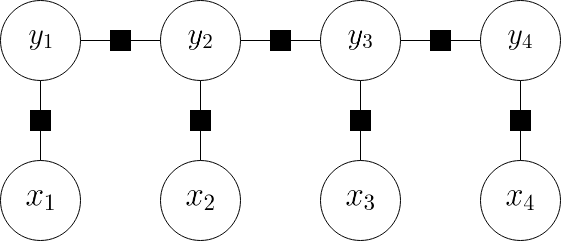

Możemy wówczas przekształcić równanie $(2)$ do postaci:

$$p(\mathbf{y} | \mathbf{X}) = \frac{1}{Z(\mathbf{X})} \prod_{t=1}^\mathcal{T} \exp\left(a(y_t, y_{t-1}) + b(y_t, \mathbf{x}_t)\right). \tag{4}$$

Korzystając z własności potęgowania zamienimy iloczyny na sumy:

$$p(\mathbf{y} | \mathbf{X}) = \frac{\exp\left(\sum_{t=2}^{\mathcal{T}}a(y_t, y_{t-1}) + \sum_{t=1}^{\mathcal{T}}b(y_t, \mathbf{x}_t)\right)}{Z(\mathbf{X})}. \tag{5}$$

Ostatnią elementem równania jest funkcja $Z(\mathbf{X})$ - suma dla wszystkich możliwych kombinacji w zbiorze etykiet w każdym kroku czasowym:

$$Z(\mathbf{X}) = \sum_{y'_1} \sum_{y'_2} \dots \sum_{y'_\mathcal{T}} \exp\left(\sum_{t=2}^{\mathcal{T}}a(y'_t, y'_{t-1}) + \sum_{t=1}^{\mathcal{T}}b(y'_t, \mathbf{x}_t)\right) \tag{6}$$

Wartość tej funkcji możemy obliczyć wykorzystując programowanie dynamiczne - algorytm forward. Algorytm prezentuje się następująco:

1. Zainicjalizuj wartości $\alpha$ wg wzoru dla każdej etykiety (nie rozpatrujemy początkowych score'ów, choć moglibyśmy):

$$\alpha_1(y'_1) = \sum_{y'1} \exp\left(b(y'_1, \mathbf{x}_1)\right) \tag{7}$$

2. Aktualizuj wartości $\alpha$ dla każdego kolejnego kroku czasowego $t=2 \rightarrow \mathcal{T}$ oraz każdej etykiety wg wzoru:

$$\log\alpha_t(y'_t) = \log\sum_{y'_t}\exp\left(a(y'_t, y_{t-1}) + b(y'_t, \mathbf{x}_t) + \log\alpha_{t-1}(y'_t))\right) \tag{8}$$

3. Oblicz wartość funkcji $Z(\mathbf{X})$ wg wzoru:

$$Z(\mathbf{X}) = \sum_{y'_\mathcal{T}} \exp\left(b(y'_\mathcal{T}, \mathbf{x}_\mathcal{T}) + \log\alpha_{\mathcal{T}-1}(y'_\mathcal{T}))\right) \tag{9}$$

Pamiętamy o tricku `logsumexp`.

## Uczenie modelu

CRF uczony jest metodą gradientową. Musimy zatem zdefiniować funkcję celu - w tym przypadku będzie to *negative log-likelihood* (NLL-loss):

$$-\log p(\mathbf{y} | \mathbf{X}) = -\log\left(\frac{\exp\left(\sum_{t=2}^{\mathcal{T}}a(y_t, y_{t-1}) + \sum_{t=1}^{\mathcal{T}}b(y_t, \mathbf{x}_t)\right)}{Z(\mathbf{X})}\right) = \log\left(Z(\mathbf{X})\right) - \left(\sum_{t=2}^{\mathcal{T}}a(y_t, y_{t-1}) + \sum_{t=1}^{\mathcal{T}}b(y_t, \mathbf{x}_t)\right). \tag{10}$$

## Wyszukiwanie najlepszej sekwencji etykiet

Aby znaleźć sekwencję etykiet, które maksymalizują prawdopodobieństwo $p(\mathbf{y} | \mathbf{X})$ moglibyśmy zastosować algorytm backward i przejść przez sekwencję w tył. Dla każdego kroku można by znaleźć etykietę maksymalizującą prawdopodobieństwo $p(\mathbf{y} | \mathbf{X})$ wg wzoru ($\beta$ to score'y z algorytmu backward):

$$p(y_t | \mathbf{X}) = \frac{\exp\left(b(y_t, \mathbf{x}_t) + \log\alpha_{t-1}(y_t)) + \log\beta_{t+1}(y_t)\right)}{\sum_{y'_t}\exp\left(b(y'_t, \mathbf{x}_t) + \log\alpha_{t-1}(y'_t)) + \log\beta_{t+1}(y'_t)\right)}, \tag{11}$$

a następnie wybrać najbardziej prawdopodobną sekwencję etykiet maksymalizując to prawdopodobieństwo. Zamiast tego możemy jednak zastosować algorytm Viterbiego: będziemy śledzić maksymalne score'y osiągane w każdym kroku w algorytmie forward, a po przejściu przez całą sekwencję, będziemy podążać według etykiet o najwyższych wynikach.


In [4]:
class CRF(nn.Module):
    """
    Linear-chain Conditional Random Field (CRF).

    based on: https://github.com/mtreviso/linear-chain-crf/blob/master/crf_vectorized.py

    Args:
        nb_labels (int): number of labels in your dataset.
    """

    def __init__(self, nb_labels):
        super().__init__()

        self.nb_labels = nb_labels
        self.PAD_ID = -1

        self.transitions = nn.Parameter(
            torch.empty(self.nb_labels + 1, self.nb_labels + 1)
        )
        nn.init.uniform_(self.transitions, -0.1, 0.1)
        self.transitions.data[self.PAD_ID, :] = -10000.0
        self.transitions.data[:, self.PAD_ID] = -10000.0

    def forward(self, x, mask=None):
        """Select best path for given data."""
        return self.decode(x, mask=mask)

    def log_likelihood(self, emissions, labels, mask=None):
        """Compute the probability of a sequence of labels given a sequence of
        emissions scores.
        Args:
            emissions (torch.Tensor): Sequence of emissions for each label.
                Shape of (batch_size, seq_len, nb_labels).
            labels (torch.LongTensor): Sequence of labels.
                Shape of (batch_size, seq_len).
            mask (torch.FloatTensor, optional): Tensor representing valid positions.
                If None, all positions are considered valid.
                Shape of (batch_size, seq_len).
        Returns:
            torch.Tensor: the log-likelihoods for each sequence in the batch.
                Shape of (batch_size,)
        """
        if mask is None:
            mask = torch.ones(emissions.shape[:2], dtype=torch.float)

        scores = self._compute_scores(emissions, labels, mask=mask)
        partition = self._compute_log_partition(emissions, mask=mask)
        return scores - partition

    def decode(self, emissions, mask=None):
        """Find the most probable sequence of labels given the emissions using
        the Viterbi algorithm.
        Args:
            emissions (torch.Tensor): Sequence of emissions for each label.
                Shape (batch_size, seq_len, nb_labels).
            mask (torch.FloatTensor, optional): Tensor representing valid positions.
                If None, all positions are considered valid.
                Shape (batch_size, seq_len).
        Returns:
            torch.Tensor: the viterbi score for the for each batch.
                Shape of (batch_size,)
            list of lists: the best viterbi sequence of labels for each batch.
        """
        if mask is None:
            mask = torch.ones(emissions.shape[:2], dtype=torch.float)

        scores, sequences = self._viterbi_decode(emissions, mask)
        return scores, sequences

    def _compute_scores(self, emissions, labels, mask):
        """Compute the scores for a given batch of emissions with their labels.
        Args:
            emissions (torch.Tensor): (batch_size, seq_len, nb_labels)
            labels (Torch.LongTensor): (batch_size, seq_len)
            mask (Torch.FloatTensor): (batch_size, seq_len)
        Returns:
            torch.Tensor: Scores for each batch.
                Shape of (batch_size,)
        """
        batch_size, seq_length = labels.shape
        scores = torch.zeros(batch_size)

        current = labels[:, 0]

        # add the [unary] emission scores for the first labels for each batch
        # for all batches, the first label, see the correspondent emissions
        # for the first labels (which is a list of ids):
        # emissions[:, 0, [label_1, label_2, ..., label_nblabels]]
        scores += emissions[:, 0].gather(1, current.unsqueeze(1)).squeeze()

        # now lets do this for each remaining labels
        for i in range(1, seq_length):
            # we could: iterate over batches, check if we reached a mask symbol
            # and stop the iteration, but vecotrizing is faster,
            # so instead we perform an element-wise multiplication
            is_valid = mask[:, i].int()

            previous = current
            current = labels[:, i]

            # calculate emission and transition scores as we did before
            e_scores = emissions[:, i].gather(1, current.unsqueeze(1)).squeeze()
            t_scores = self.transitions[previous, current]

            # apply the mask
            e_scores = e_scores * is_valid
            t_scores = t_scores * is_valid

            scores += e_scores + t_scores

        return scores

    def _compute_log_partition(self, emissions, mask):
        """Compute the partition function in log-space using the forward-algorithm.
        Args:
            emissions (torch.Tensor): (batch_size, seq_len, nb_labels)
            mask (Torch.FloatTensor): (batch_size, seq_len)
        Returns:
            torch.Tensor: the partition scores for each batch.
                Shape of (batch_size,)
        """
        batch_size, seq_length, nb_labels = emissions.shape

        alphas = emissions[:, 0]

        for i in range(1, seq_length):
            # (bs, nb_labels) -> (bs, 1, nb_labels)
            e_scores = emissions[:, i].unsqueeze(1)

            # (nb_labels, nb_labels) -> (bs, nb_labels, nb_labels)
            t_scores = self.transitions.unsqueeze(0)

            # (bs, nb_labels)  -> (bs, nb_labels, 1)
            a_scores = alphas.unsqueeze(2)

            scores = e_scores + t_scores + a_scores
            new_alphas = torch.logsumexp(scores, dim=1)

            # set alphas if the mask is valid, otherwise keep the current values
            is_valid = mask[:, i].unsqueeze(-1).int()
            alphas = is_valid * new_alphas + (1 - is_valid) * alphas

        # return a *log* of sums of exps
        return torch.logsumexp(alphas, dim=1)

    def _viterbi_decode(self, emissions, mask):
        """Compute the viterbi algorithm to find the most probable sequence of labels
        given a sequence of emissions.
        Args:
            emissions (torch.Tensor): (batch_size, seq_len, nb_labels)
            mask (Torch.FloatTensor): (batch_size, seq_len)
        Returns:
            torch.Tensor: the viterbi score for the for each batch.
                Shape of (batch_size,)
            torch.Tensor: the best viterbi sequence of labels for each batch
        """
        batch_size, seq_length, nb_labels = emissions.shape

        alphas = emissions[:, 0]

        backpointers = []

        for i in range(1, seq_length):
            # (bs, nb_labels) -> (bs, 1, nb_labels)
            e_scores = emissions[:, i].unsqueeze(1)

            # (nb_labels, nb_labels) -> (bs, nb_labels, nb_labels)
            t_scores = self.transitions.unsqueeze(0)

            # (bs, nb_labels)  -> (bs, nb_labels, 1)
            a_scores = alphas.unsqueeze(2)

            # combine current scores with previous alphas
            scores = e_scores + t_scores + a_scores

            # so far is exactly like the forward algorithm,
            # but now, instead of calculating the logsumexp,
            # we will find the highest score and the label associated with it
            max_scores, max_score_labels = torch.max(scores, dim=1)

            # set alphas if the mask is valid, otherwise keep the current values
            is_valid = mask[:, i].unsqueeze(-1)
            alphas = is_valid * max_scores + (1 - is_valid) * alphas

            # add the max_score_labels for our list of backpointers
            # max_scores has shape (batch_size, nb_labels) so we transpose it to
            # be compatible with our previous loopy version of viterbi
            backpointers.append(max_score_labels.t())

        # get the final most probable score and the final most probable label
        max_final_scores, max_final_labels = torch.max(alphas, dim=1)

        # find the best sequence of labels for each sample in the batch
        best_sequences = []
        emission_lengths = mask.int().sum(dim=1)
        for i in range(batch_size):
            # recover the original sentence length for the i-th sample in the batch
            sample_length = emission_lengths[i].item()

            # recover the max label for the last timestep
            sample_final_label = max_final_labels[i].item()

            # limit the backpointers until the last but one
            # since the last corresponds to the sample_final_label
            sample_backpointers = backpointers[: sample_length - 1]

            # follow the backpointers to build the sequence of labels
            sample_path = self._find_best_path(
                i, sample_final_label, sample_backpointers
            )

            # add this path to the list of best sequences
            best_sequences.append(sample_path)

        return max_final_scores, torch.tensor(best_sequences)

    def _find_best_path(self, sample_id, best_label, backpointers):
        """Auxiliary function to find the best path sequence for a specific sample.
        Args:
            sample_id (int): sample index in the range [0, batch_size)
            best_label (int): label which maximizes the final score
            backpointers (list of lists of tensors): list of pointers with
            shape (seq_len_i-1, nb_labels, batch_size) where seq_len_i
            represents the length of the ith sample in the batch
        Returns:
            list of ints: a list of label indexes representing the bast path
        """
        # add the final best_label to our best path
        best_path = [best_label]

        # traverse the backpointers in backwards
        for backpointers_t in reversed(backpointers):
            # recover the best_label at this timestep
            best_label = backpointers_t[best_label][sample_id].item()
            best_path.append(best_label)

        return best_path[::-1]


Klasa `SequenceClassifier` będzie klasą pomocniczą, na której bazować będą wszystkie dalsze modele w celu ujednolicenia interfejsu.


In [5]:
class SequenceClassifier(nn.Module):
    """Helper class for implementing sequence classifier."""

    def __init__(self, nb_labels: int, x_size: int):
        """
        :param nb_labels: number of labels in the target (shape of the output layer)
        :param x_size: size of x input to determin first layer size
        """
        super().__init__()
        self.nb_labels = nb_labels
        self.x_size = x_size

    def forward(self, *args, **kwargs):
        """Pass data through the model.

        .. note: this function should return values used for calculating the loss function
        """
        raise NotImplementedError

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        """Run prediction on given data.

        .. note: this function should return labels for all corresponding features

        :param x: input features tensor of shape (batch_size, seq_length, x_size)
        :returns: labels tensor of shape (batch_size, seq_length,)
        """
        raise NotImplementedError


## Zbiory danych

Będziemy pracowali na dwóch zbiorach danych. Pierwszy to prosty zbiór wygenerowany przy użyciu HMM-a z poprzednich zajęć - gdzie wektor cech $\mathbf{X}$ stanowi pojedyncza liczba, mówiąca o stanie ukrytym (H lub L), nastomiast etykiety to symbole aminokwasów (mamy zatem cztery klasy).

Drugi ze zbiorów to zbiór sekwencji obrazków przedstawiających litery pisane w słowach angielskich. Zbiór ten pochodzi z artykułu Taskar et al “Max-margin markov random fields”. Aby uprościć nieco zadanie, został on pozbawiony pierwszych liter każdego zdania (były one rozpoczynane wielkimi literami). Mamy tu zatem 26 klas, odpowiadających każdej literze alfabetu.


In [6]:
# zbiór danych z HMM
def prepare_gene_dataset():
    with open("gene.pkl", "rb") as fp:
        gene_dataset = pickle.load(fp)

    (X_train, y_train), (X_test, y_test) = gene_dataset
    le = LabelEncoder().fit(np.unique(np.concatenate(y_train)))

    X_train = torch.from_numpy(X_train).unsqueeze(-1).float()
    y_train = torch.tensor([le.transform(seq) for seq in y_train])
    X_test = torch.from_numpy(X_test).unsqueeze(-1).float()
    y_test = torch.tensor([le.transform(seq) for seq in y_test])

    def display_info_fn(
        X: torch.Tensor,
        y: torch.Tensor,
        model: Optional[SequenceClassifier] = None,
        idx: Optional[int] = None,
    ):
        if idx is None:
            idx = randrange(y.shape[0])
        x = X[[idx]]
        y_true = y[[idx]]
        print(
            "y_true: ",
            y_true.squeeze(0).tolist(),
            le.inverse_transform(y_true.squeeze(0)).tolist(),
        )

        if model is not None:
            with torch.no_grad():
                y_pred = model.predict(x)
            print("y_pred: ", y_pred[0].tolist(), le.inverse_transform(y_pred[0]).tolist())
        print("----------")

    return ((X_train, y_train), (X_test, y_test)), display_info_fn


gene_dataset, gene_info_fn = prepare_gene_dataset()

for idx in range(5):
    gene_info_fn(*gene_dataset[1], idx=idx)


y_true:  [3, 3, 3, 0, 0, 2, 3, 3, 3, 0] ['T', 'T', 'T', 'A', 'A', 'G', 'T', 'T', 'T', 'A']
----------
y_true:  [1, 1, 2, 2, 2, 0, 3, 3, 3, 3] ['C', 'C', 'G', 'G', 'G', 'A', 'T', 'T', 'T', 'T']
----------
y_true:  [0, 1, 0, 0, 1, 1, 3, 1, 0, 2] ['A', 'C', 'A', 'A', 'C', 'C', 'T', 'C', 'A', 'G']
----------
y_true:  [2, 3, 1, 1, 2, 0, 0, 2, 1, 3] ['G', 'T', 'C', 'C', 'G', 'A', 'A', 'G', 'C', 'T']
----------
y_true:  [3, 0, 0, 2, 3, 3, 1, 0, 3, 1] ['T', 'A', 'A', 'G', 'T', 'T', 'C', 'A', 'T', 'C']
----------


y_true:  [20, 25, 25, 11, 4, 12, 4, 13, 19] ['u', 'z', 'z', 'l', 'e', 'm', 'e', 'n', 't']
----------


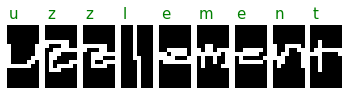

y_true:  [7, 0, 3, 14, 22] ['h', 'a', 'd', 'o', 'w']
----------


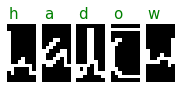

y_true:  [20, 5, 5] ['u', 'f', 'f']
----------


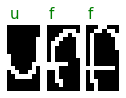

y_true:  [4, 17, 14] ['e', 'r', 'o']
----------


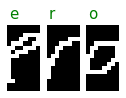

y_true:  [0, 10, 4] ['a', 'k', 'e']
----------


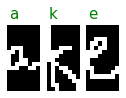

In [7]:
# zbiór danych - obrazy liter
LETTERS = list("abcdefghijklmnopqrstuvwxyz")


def plot_words_with_labels(images, labels, predictions=None, title=""):
    if predictions is None:
        predictions = [[]] * len(labels)
    max_len = max(map(len, images))
    fig, axes = plt.subplots(
        len(images),
        max_len,
        figsize=(max_len // 1.5, len(images) * 2),
        squeeze=False,
    )
    for row_idx, axes_row in enumerate(axes):
        for col_idx, ax in enumerate(axes_row):
            if col_idx < len(images[row_idx]):
                image = images[row_idx][col_idx]
                label = (
                    LETTERS[labels[row_idx][col_idx]]
                    if labels[row_idx][col_idx] != len(LETTERS)
                    else ""
                )
                prediction = (
                    LETTERS[predictions[row_idx][col_idx]]
                    if col_idx < len(predictions[row_idx])
                    and predictions[row_idx][col_idx] != len(LETTERS)
                    else ""
                )
                ax.imshow(image, cmap="gray")
                ax.text(0, -2, label, color="g", size=15)
                ax.text(0, 20, prediction, color="r", size=15)
            ax.axis("off")
    fig.suptitle(title, fontsize=16)
    plt.show()


def prepare_letters_dataset():
    with open("letters.pkl", "rb") as fp:
        letters_dataset = pickle.load(fp)

    (X_train, y_train), (X_test, y_test) = letters_dataset
    le = LabelEncoder().fit(np.unique(np.concatenate(y_train)))

    # pad train dataset
    train_seq_length = max(y.shape[0] for y in y_train)
    _, *obj_shape = X_train[0].shape
    X_train = torch.tensor(
        [
            np.pad(
                row.astype("float32"),
                ((0, train_seq_length - len(row)), (0, 0), (0, 0)),
                constant_values=len(LETTERS),
            )
            for row in X_train
        ]
    )
    y_train = torch.tensor(
        [
            np.pad(row, (0, train_seq_length - len(row)), constant_values=len(LETTERS))
            for row in y_train
        ]
    )

    # pad test dataset
    test_seq_length = max(y.shape[0] for y in y_test)
    X_test = torch.tensor(
        [
            np.pad(
                row.astype("float32"),
                ((0, test_seq_length - len(row)), (0, 0), (0, 0)),
                constant_values=len(LETTERS),
            )
            for row in X_test
        ]
    )
    y_test = torch.tensor(
        [
            np.pad(row, (0, test_seq_length - len(row)), constant_values=len(LETTERS))
            for row in y_test
        ]
    )

    def display_info_fn(
        X: torch.Tensor,
        y: torch.Tensor,
        model: Optional[SequenceClassifier] = None,
        idx: Optional[int] = None,
    ):
        if idx is None:
            idx = randrange(y.shape[0])
        x = X[[idx]]
        y_true = y[[idx]]
        y_pred = None
        
        try:
            last = y_true.squeeze(0).tolist().index(len(LETTERS))
        except ValueError:
            last = y_true.shape[1]
                                                    
        
        print(
            "y_true: ",
            y_true.squeeze(0).tolist()[:last],
            [LETTERS[idx] for idx in y_true.squeeze(0)[:last]],
        )

        if model is not None:
            with torch.no_grad():
                y_pred = model.predict(x)
            print(
                "y_pred: ",
                y_pred[0].tolist()[:last],
                [LETTERS[idx] for idx in y_pred[0][:last]],
            )
            y_pred = y_pred[:, :last]
            
        print("----------")

        plot_words_with_labels(x[:, :last], y_true[:, :last], y_pred)

    return ((X_train, y_train), (X_test, y_test)), display_info_fn


letters_dataset, letters_info_fn = prepare_letters_dataset()

for idx in range(5):
    letters_info_fn(*letters_dataset[1], idx=idx)


Poniżej definiujemy pętlę uczenia. Deklarujemy w niej zbiory danych oraz parametry uczenia, a także logujemy metryki (wart. funkcji kosztu oraz średnią wartość accuracy). Na koniec wyświetlony zostanie wykres oraz przykłady predykcji zastosowanego modelu.


In [8]:
def get_mask(X: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """Get mask for padding by examining contents of the X tensor."""
    pad_id = torch.max(y).int().item()
    flattened_X = X.view(*X.shape[:2], -1)
    mask = (torch.eq(flattened_X, pad_id).sum(-1) != flattened_X.shape[-1]).bool()
    return mask


def train(
    model: SequenceClassifier,
    loss_fn: Callable[
        [torch.Tensor, torch.Tensor, Optional[torch.Tensor], SequenceClassifier],
        torch.Tensor,
    ],
    dataset: Tuple[
        Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor, torch.Tensor]
    ],
    display_info_fn: Callable[
        [torch.Tensor, torch.Tensor, SequenceClassifier, int], None
    ],
    n_epochs: int,
    lr: float = 0.001,
    batch_size: int = 32,
    use_mask: bool = False,
    log_transitions: bool = False
):
    """Training loop.
    
    :param model: SequenceClassifier instance
    :param loss_fn: callable, which receives feature vector and labels,
        ptional mask and model and calculates the loss function
        for training the model
    :param dataset: tuple (X_train, y_train), (X_test, y_test)
        containing train and test dataset
    :param display_info_fn: callable accepting feature vectors, labels,
        together with the model and optional indices to display some
        information on the results of the model (defined along datasets)
    :param n_epochs: number of epochs to use for training
    :param lr: learning rate to be used in Adam optimizer
    :param batch_size: batch_size set for training the model
    :param use_mask: boolean flag whether to look for padding values in data
    :param log_transitions: boolean flag whether to log transitions values
        during training (used for models with CRF)
    :returns: trained model and logging dictionary
    """
    (X_train, y_train), (X_test, y_test) = dataset
    mask = None
    
    if grading:
        batch_size = DEFAULT_BATCH

    train_dataset = TensorDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TensorDataset(X_test, y_test)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    log = {"train_loss": [], "test_loss": [], "train_acc": [], "test_acc": []}
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    transitions = []

    for epoch in trange(n_epochs):
        if epoch == DEFAULT_EPOCHS and grading:
            break
        
        try:
            model.zero_grad()

            # train
            for X, y in train_dataloader:
                if use_mask:
                    mask = get_mask(X, y)

                y_pred = model(X)
                loss = loss_fn(y_pred, y, mask=mask, model=model)
                loss.backward()
                optimizer.step()

                train_loss.append(loss.detach().item())
                with torch.no_grad():
                    train_acc.append(
                        accuracy_score(y.view(-1), model.predict(X).view(-1))
                    )

            # eval
            with torch.no_grad():
                for X, y in test_dataloader:
                    if use_mask:
                        mask = get_mask(X, y)

                    y_pred = model(X)
                    loss = loss_fn(y_pred, y, mask=mask, model=model)

                    test_loss.append(loss.item())
                    test_acc.append(
                        accuracy_score(y.view(-1), model.predict(X).view(-1))
                    )

            # log
            log["train_loss"].append(np.mean(train_loss))
            log["test_loss"].append(np.mean(test_loss))
            log["train_acc"].append(np.mean(train_acc))
            log["test_acc"].append(np.mean(test_acc))
            if log_transitions:
                transitions.append(model.crf.transitions.detach().numpy().copy())
            train_loss = []
            test_loss = []
            train_acc = []
            test_acc = []

        except KeyboardInterrupt:
            break

    pd.DataFrame(log).reset_index().rename(columns={"index": "epoch"}).plot(
        x="epoch",
        y=["train_loss", "test_loss", "train_acc", "test_acc"],
        secondary_y=["train_acc", "test_acc"],
    )

    for _ in range(5):
        display_info_fn(X_test, y_test, model)
    
    if log_transitions:
        log["transitions"] = transitions

    return model, log


# Prosty klasyfikator

Jako pierwszy zaimplementowany został prosty klasyfikator, w którym nie będziemy rozpatrywali zależności pomiędzy kolejnymi elementami sekwencji. Następnie model jest testowany dla obu przygotowanych zbiorów danych.


In [9]:
class MLPClassifier(SequenceClassifier):
    """Simple MLP model, treating sequences as IID."""

    def __init__(self, hidden_sizes: Optional[List[int]] = None, *args, **kwargs):
        super().__init__(*args, **kwargs)

        hidden_sizes = [self.x_size, *(hidden_sizes or [])]
        self.mlp = nn.ModuleList(
            [
                nn.Linear(in_size, out_size)
                for in_size, out_size in zip(hidden_sizes, hidden_sizes[1:])
            ]
        )
        self.out = nn.Linear(hidden_sizes[-1], self.nb_labels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(*x.shape[:2], -1)
        batch_size, seq_length, h_size = x.shape

        x = x.view(-1, h_size)
        for layer in self.mlp:
            x = torch.relu(layer(x))
        x = self.out(x)

        return x.view(batch_size, seq_length, self.nb_labels)

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        y = self.forward(x)
        softmaxed = torch.log_softmax(y, dim=-1)
        return torch.max(softmaxed, dim=-1)[1]


def mlp_clf_loss(
    y_pred: torch.Tensor, y_true: torch.Tensor, mask: Optional[torch.Tensor], model: MLPClassifier,
) -> torch.Tensor:
    """Loss for evaluating MLP Classifier performance.
    
    .. note: model is not used here.
    """
    criterion = nn.CrossEntropyLoss()

    if mask is None:
        mask = torch.ones(y_true.shape[:2], dtype=torch.bool)
    
    return criterion(y_pred[mask], y_true[mask])



y_true:  [1, 0, 0, 0, 0, 3, 3, 0, 1, 3] ['C', 'A', 'A', 'A', 'A', 'T', 'T', 'A', 'C', 'T']
y_pred:  [3, 2, 2, 3, 3, 3, 3, 3, 2, 3] ['T', 'G', 'G', 'T', 'T', 'T', 'T', 'T', 'G', 'T']
----------
y_true:  [1, 2, 0, 3, 0, 3, 3, 3, 3, 3] ['C', 'G', 'A', 'T', 'A', 'T', 'T', 'T', 'T', 'T']
y_pred:  [3, 2, 3, 3, 3, 3, 3, 3, 3, 2] ['T', 'G', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'G']
----------
y_true:  [2, 2, 3, 1, 2, 3, 3, 0, 3, 2] ['G', 'G', 'T', 'C', 'G', 'T', 'T', 'A', 'T', 'G']
y_pred:  [2, 2, 3, 2, 3, 2, 3, 2, 3, 2] ['G', 'G', 'T', 'G', 'T', 'G', 'T', 'G', 'T', 'G']
----------
y_true:  [3, 3, 3, 2, 3, 0, 2, 1, 0, 0] ['T', 'T', 'T', 'G', 'T', 'A', 'G', 'C', 'A', 'A']
y_pred:  [3, 2, 3, 2, 2, 3, 3, 2, 3, 3] ['T', 'G', 'T', 'G', 'G', 'T', 'T', 'G', 'T', 'T']
----------
y_true:  [2, 0, 2, 2, 3, 3, 3, 0, 3, 3] ['G', 'A', 'G', 'G', 'T', 'T', 'T', 'A', 'T', 'T']
y_pred:  [2, 2, 3, 2, 2, 3, 2, 3, 3, 2] ['G', 'G', 'T', 'G', 'G', 'T', 'G', 'T', 'T', 'G']
----------


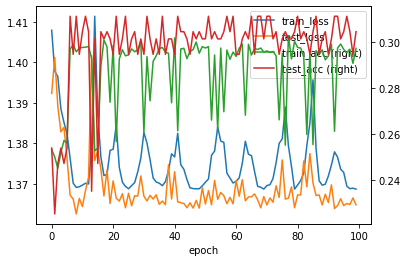

In [10]:
nb_labels = torch.max(gene_dataset[0][1]).item() + 1
x_size = np.prod(gene_dataset[0][0].shape[2:])
mlp_gene_model = MLPClassifier([3], nb_labels, x_size)
_, mlp_gene_log = train(
    model=mlp_gene_model,
    loss_fn=mlp_clf_loss,
    dataset=gene_dataset,
    display_info_fn=gene_info_fn,
    n_epochs=100,
    lr=0.01,
    batch_size=32,
    use_mask=False,
)



y_true:  [20, 25, 25] ['u', 'z', 'z']
y_pred:  [20, 25, 25] ['u', 'z', 'z']
----------


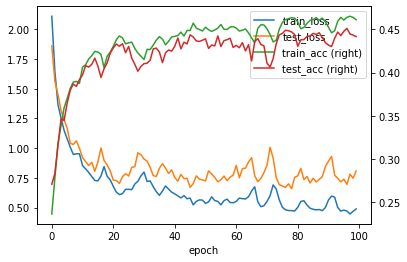

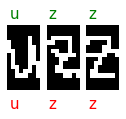

y_true:  [14, 17, 12, 0, 11, 8, 25, 0, 19, 8, 14, 13] ['o', 'r', 'm', 'a', 'l', 'i', 'z', 'a', 't', 'i', 'o', 'n']
y_pred:  [14, 17, 12, 0, 4, 8, 25, 0, 5, 8, 14, 13] ['o', 'r', 'm', 'a', 'e', 'i', 'z', 'a', 'f', 'i', 'o', 'n']
----------


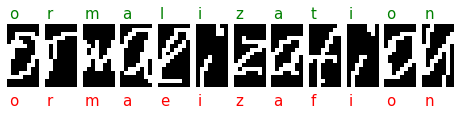

y_true:  [4, 0, 17, 1, 14, 14, 10] ['e', 'a', 'r', 'b', 'o', 'o', 'k']
y_pred:  [0, 13, 17, 14, 14, 4, 12] ['a', 'n', 'r', 'o', 'o', 'e', 'm']
----------


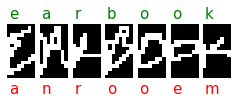

y_true:  [17, 8, 6, 7, 19, 5, 20, 11, 11, 24] ['r', 'i', 'g', 'h', 't', 'f', 'u', 'l', 'l', 'y']
y_pred:  [17, 8, 6, 7, 10, 15, 0, 11, 11, 6] ['r', 'i', 'g', 'h', 'k', 'p', 'a', 'l', 'l', 'g']
----------


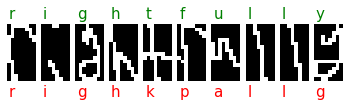

y_true:  [24, 11, 14, 15, 7, 14, 13, 4] ['y', 'l', 'o', 'p', 'h', 'o', 'n', 'e']
y_pred:  [24, 11, 14, 15, 7, 14, 13, 4] ['y', 'l', 'o', 'p', 'h', 'o', 'n', 'e']
----------


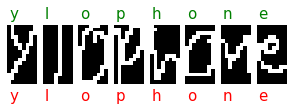

In [11]:
nb_labels = torch.max(letters_dataset[0][1]).item()
x_size = np.prod(letters_dataset[0][0].shape[2:])
mlp_letters_model = MLPClassifier([64], nb_labels, x_size)
_, mlp_letters_log = train(
    model=mlp_letters_model,
    loss_fn=mlp_clf_loss,
    dataset=letters_dataset,
    display_info_fn=letters_info_fn,
    n_epochs=100,
    lr=0.001,
    batch_size=32,
    use_mask=True,
)


# Zadanie 1 (1,5 + 0,5 pkt.)

Przygotuj prosty model z CRF-em z siecią MLP jako funkcją $b$ (opisującą, jak prawdopodobna jest etykieta $y_t$ przy danym wektorze cech $\mathbf{x}_t$) oraz funkcję kosztu, która posłuży do jego wytrenowania.

1. Przygotuj funkcję `__init__`. Model powinien zawierać sekwencję warstw w pełni połączonych (rozmiary ustawiane argumentem `hidden_sizes` - zobacz). UWAGA: zwróć uwagę, że CRF stosuje macierz o 1 większą od liczby klas - zwróć na to uwagę budując ostatnią warstwę w modelu)

2. Przygotuj funkcję `forward`. Należy w niej przetworzyć dane wejściowe przez warstwy w pełni połączone (zwróć uwagę na niezbędne zmiany rozmiaru tensorów), w wyniku czego powinniśmy otrzymać tensor emisji (o odpowiednim rozmiarze - zobacz definicję klasy `CRF`). Tensor emisji będzie potrzebny do obliczenia funkcji kosztu oraz predykcji.

3. Przygotuj funkcję `predict`. Wykorzystaj emisje obliczone w `forward` do ustalenia najbardziej prawdopodobnej sekwencji etykiet, wykorzystując metody klasy `CRF`.

Następnie zaimplementuj funkcję kosztu (negative log-likelihood), odpowiednio wypełniając funkcję `mlpcrf_clf_loss`. Wykorzystaj emisje (które pochodzą z metody `forward` `MLPCRFClassifier`) oraz prawdziwe etykiety, a także maskę (podawaną do funkcji lub ustalaną automatycznie) oraz odpowiednią metode klasy `CRF`.

Zbadaj przygotowany model pod względem hiperparametrów uczenia oraz liczby i wielkości warstw w modelu; wyciągnij wnioski


In [12]:
class MLPCRFClassifier(SequenceClassifier):
    """Simple MLP model with CRF."""

    def __init__(self, hidden_sizes: Optional[List[int]] = None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.crf = CRF(self.nb_labels)
        
        # prepare model's layers and assign to the model according to `hidden_sizes`
        # TU WPISZ KOD
        hidden_sizes = [self.x_size, *(hidden_sizes or [])]
        self.mlp = nn.ModuleList(
            [
                nn.Linear(in_size, out_size)
                for in_size, out_size in zip(hidden_sizes, hidden_sizes[1:])
            ])
        self.out = nn.Linear(hidden_sizes[-1], self.nb_labels+1)
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        emissions = None
        # forward data through the model to generate emissions
        # TU WPISZ KOD
        x = x.view(*x.shape[:2], -1)
        batch_size, seq_length, h_size = x.shape

        x = x.view(-1, h_size)
        for layer in self.mlp:
            x = torch.relu(layer(x))
        x = self.out(x)
        
        emissions = x.view(batch_size, seq_length, self.nb_labels + 1)
        return emissions

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        emissions = self.forward(x)
        prediction = None
        
        # use emissions to generate the most probable sequence of labels
        # TU WPISZ KOD
        _, prediction = self.crf.forward(emissions)


        return prediction


In [13]:
def mlpcrf_clf_loss(
    emissions: torch.Tensor,
    y_true: torch.Tensor,
    mask: Optional[torch.Tensor],
    model: MLPCRFClassifier,
) -> torch.Tensor:
    """Loss for evaluating MLP-CRF Classifier performance."""
    if mask is None:
        mask = torch.ones(y_true.shape[:2], dtype=torch.bool)
        
    loss = None
    
    # use emissions and ground truth to calculate the loss function
    # TU WPISZ KOD
    
    loss = model.crf.log_likelihood(emissions, y_true, mask)

    return -loss.mean()



y_true:  [0, 2, 3, 1, 1, 0, 2, 0, 2, 1] ['A', 'G', 'T', 'C', 'C', 'A', 'G', 'A', 'G', 'C']
y_pred:  [0, 1, 2, 0, 3, 0, 3, 0, 1, 3] ['A', 'C', 'G', 'A', 'T', 'A', 'T', 'A', 'C', 'T']
----------
y_true:  [1, 2, 0, 1, 1, 0, 1, 3, 1, 2] ['C', 'G', 'A', 'C', 'C', 'A', 'C', 'T', 'C', 'G']
y_pred:  [0, 3, 2, 0, 1, 3, 2, 0, 0, 1] ['A', 'T', 'G', 'A', 'C', 'T', 'G', 'A', 'A', 'C']
----------
y_true:  [0, 1, 2, 0, 1, 0, 2, 2, 1, 3] ['A', 'C', 'G', 'A', 'C', 'A', 'G', 'G', 'C', 'T']
y_pred:  [0, 3, 2, 0, 3, 0, 3, 0, 0, 1] ['A', 'T', 'G', 'A', 'T', 'A', 'T', 'A', 'A', 'C']
----------
y_true:  [2, 0, 3, 0, 3, 2, 3, 3, 1, 1] ['G', 'A', 'T', 'A', 'T', 'G', 'T', 'T', 'C', 'C']
y_pred:  [1, 3, 0, 0, 3, 2, 2, 2, 1, 3] ['C', 'T', 'A', 'A', 'T', 'G', 'G', 'G', 'C', 'T']
----------
y_true:  [3, 1, 1, 0, 3, 0, 2, 1, 1, 2] ['T', 'C', 'C', 'A', 'T', 'A', 'G', 'C', 'C', 'G']
y_pred:  [1, 1, 3, 0, 3, 0, 3, 2, 2, 1] ['C', 'C', 'T', 'A', 'T', 'A', 'T', 'G', 'G', 'C']
----------


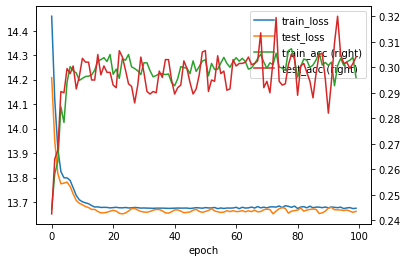

In [14]:
nb_labels = torch.max(gene_dataset[0][1]).item() + 1
x_size = np.prod(gene_dataset[0][0].shape[2:])


mlpcrf_gene_model = MLPCRFClassifier([3], nb_labels, x_size)
_, mlpcrf_gene_log = train(
    model=mlpcrf_gene_model,
    loss_fn=mlpcrf_clf_loss,
    dataset=gene_dataset,
    display_info_fn=gene_info_fn,
    n_epochs=100,
    lr=0.01,
    batch_size=200,
    use_mask=False,
    log_transitions=True,
)



y_true:  [4, 2, 14, 12, 15, 17, 4, 18, 18] ['e', 'c', 'o', 'm', 'p', 'r', 'e', 's', 's']
y_pred:  [4, 2, 14, 12, 15, 17, 4, 18, 18] ['e', 'c', 'o', 'm', 'p', 'r', 'e', 's', 's']
----------


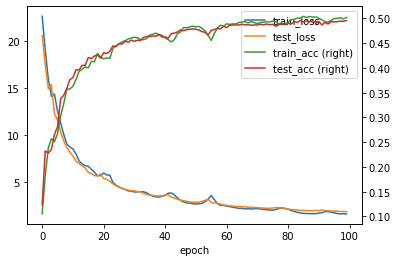

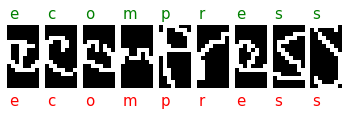

y_true:  [7, 0, 3, 14, 22] ['h', 'a', 'd', 'o', 'w']
y_pred:  [7, 0, 1, 14, 22] ['h', 'a', 'b', 'o', 'w']
----------


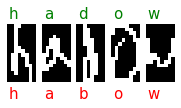

y_true:  [20, 8, 25, 25, 8, 2, 0, 11, 11, 24] ['u', 'i', 'z', 'z', 'i', 'c', 'a', 'l', 'l', 'y']
y_pred:  [20, 8, 25, 25, 8, 2, 0, 11, 11, 24] ['u', 'i', 'z', 'z', 'i', 'c', 'a', 'l', 'l', 'y']
----------


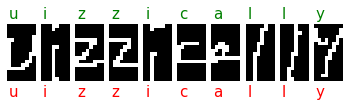

y_true:  [4, 4, 10, 4, 17] ['e', 'e', 'k', 'e', 'r']
y_pred:  [17, 0, 13, 4, 4] ['r', 'a', 'n', 'e', 'e']
----------


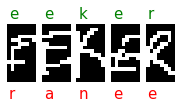

y_true:  [17, 14, 9, 4, 2, 19, 8, 14, 13, 18] ['r', 'o', 'j', 'e', 'c', 't', 'i', 'o', 'n', 's']
y_pred:  [17, 14, 9, 4, 2, 19, 8, 14, 13, 18] ['r', 'o', 'j', 'e', 'c', 't', 'i', 'o', 'n', 's']
----------


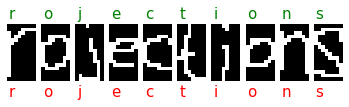

In [15]:
nb_labels = torch.max(letters_dataset[0][1]).item()
x_size = np.prod(letters_dataset[0][0].shape[2:])
mlpcrf_letters_model = MLPCRFClassifier([64], nb_labels, x_size)
_, mlpcrf_letters_log = train(
    model=mlpcrf_letters_model,
    loss_fn=mlpcrf_clf_loss,
    dataset=letters_dataset,
    display_info_fn=letters_info_fn,
    n_epochs=100,
    lr=0.001,
    batch_size=200,
    use_mask=True,
    log_transitions=True,
)


# Zadanie 2 (1 pkt.)

Podczas uczenia modelu z CRF-em jest możliwość śledzenia zmian macierzy przejść (argument `log_transitions`) - dzięki temu możliwe jest przeanalizowanie zmian score'ów przejść pomiędzy poszczególnymi etykietami. Zaimplementuj funkcję `plot_transitions`, gdzie wyświetlisz na wykresie jak poniżej historię zmian wag w tej macierzy z odpowiednimi etykietami. Uwaga: ze względu na szybkość działania, historia wyświetlana jest dla ograniczonej liczby komórek. Przeanalizuj uzyskane wykresy.

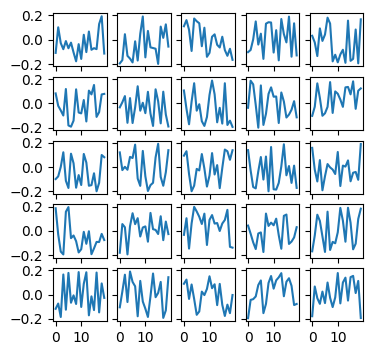


In [16]:
def plot_transitions(transitions: List[np.ndarray]):
    """Display how transitions weights changed throughout training.
    
    .. note: we limit ourselves to only 7 first labels for the sake of performance
        and do not consider padding axis (it is not trained)
    """
    LETTERS = list("abcdefghijklmnopqrstuvwxyz")
    genes = ["A","C","T","G"]
    
    size = min(transitions[0].shape[0] - 1, 7)
    fig, axes = plt.subplots(size, size, sharex=True, sharey=True, figsize=(10, 10))
    
    label_source = genes if size == 4 else LETTERS
    
    transitions = np.array(transitions)
    x = np.linspace(1,len(transitions)+1,num=len(transitions))
    for i in range(size):
        plt.setp(axes[i,0],ylabel=label_source[i])
        for j in range(size):
            axes[i][j].plot(x, transitions[:,i,j])
            axes[i][j].set_title(label_source[j])
    
    
    plt.setp(axes, xlabel='epoch')

    plt.tight_layout()
    plt.show()

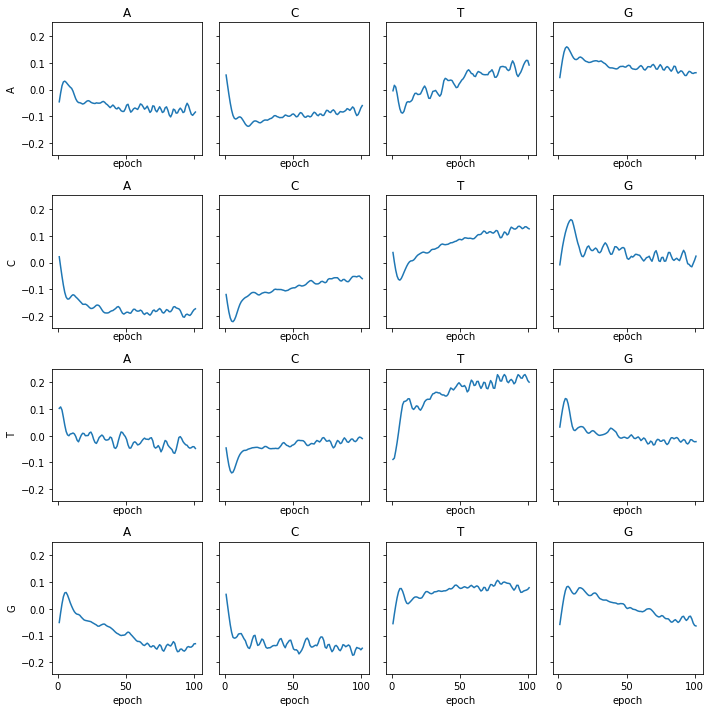

In [17]:
plot_transitions(mlpcrf_gene_log["transitions"])

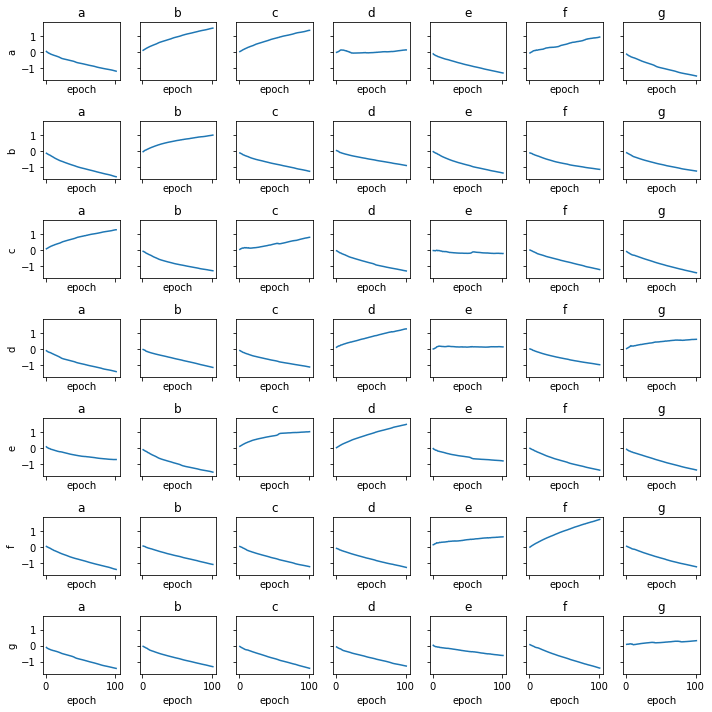

In [18]:
plot_transitions(mlpcrf_letters_log["transitions"])

# Zadanie 3 (2+ pkt.)

Rozszerz zaproponowany wcześniej model klasyfikacji z CRF-em, ulepszając wykorzystaną architekturę do obliczania funkcji $b$. Zastosuj ulepszony model ponownie dla zbioru `letters`. Przeanalizuj model pod kątem szybkości trenowania, osiąganych rezultatów oraz porównaj z poprzednimi modelami. Możesz również zmodyfikować pętlę uczenia.

Przykładowe ulepszenia:
- zastosowanie warstw konwolucyjnych
- wykorzystanie rekurencyjnych komórek

UWAGA: jeśli trenowanie trwa dłużej niż 2 minuty dla 20 epok, prosimy o umieszczenie kodu wewnątrz instrukcji:

```python
if not grading:
    do_something()
```

Wnioski oraz ew. wykresy umieść w komórce typu markdown.


In [19]:
class ConvCRFClassifier(SequenceClassifier):
    """Simple MLP model with CRF."""

    def __init__(self, conv_filters: List[int], filter_sizes: List[int],*args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.crf = CRF(self.nb_labels)
        
        # prepare model's layers and assign to the model according to `hidden_sizes`
        # TU WPISZ KOD
        
        self.model = nn.Sequential(
                nn.Conv2d(1, conv_filters[0], filter_sizes[0]),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Conv2d(conv_filters[0], conv_filters[1] , filter_sizes[1]),
                nn.ReLU(inplace=True),
        )
        
        self.out_h  = ((((16 - filter_sizes[0]) + 1) / 2) - filter_sizes[1]) + 1
        self.out_w  = ((((8 - filter_sizes[0]) + 1) / 2) - filter_sizes[1]) + 1
        
        self.linear_in_shape = int(conv_filters[1] * self.out_h * self.out_w)
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.linear_in_shape, (self.nb_labels+1))        
        ) 
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, seq_length = x.shape[:2]
        
        
        placeholder = torch.zeros((batch_size, seq_length,self.nb_labels+1))
        for i in range(seq_length):
            input = x[:,i,:].unsqueeze(1)
            cout = self.model(input)
            cout = cout.view(batch_size, -1)
            out = self.out(cout)
            placeholder[:,i] = out
            
        emissions = placeholder
        return emissions

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        emissions = self.forward(x)
        prediction = None
        
        # use emissions to generate the most probable sequence of labels
        # TU WPISZ KOD
        _, prediction = self.crf.forward(emissions)


        return prediction


y_true:  [13, 4, 23, 15, 4, 2, 19, 4, 3] ['n', 'e', 'x', 'p', 'e', 'c', 't', 'e', 'd']
y_pred:  [12, 4, 23, 15, 4, 4, 19, 4, 3] ['m', 'e', 'x', 'p', 'e', 'e', 't', 'e', 'd']
----------


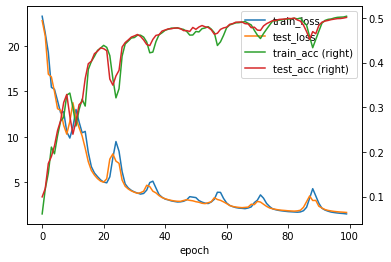

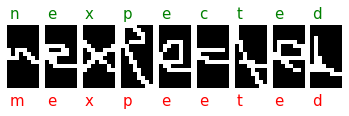

y_true:  [14, 1, 1, 11, 4] ['o', 'b', 'b', 'l', 'e']
y_pred:  [14, 1, 1, 11, 4] ['o', 'b', 'b', 'l', 'e']
----------


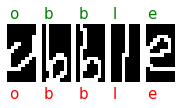

y_true:  [20, 5, 5] ['u', 'f', 'f']
y_pred:  [20, 5, 5] ['u', 'f', 'f']
----------


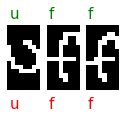

y_true:  [20, 12, 15] ['u', 'm', 'p']
y_pred:  [20, 12, 15] ['u', 'm', 'p']
----------


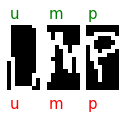

y_true:  [24, 12, 15, 0, 19, 7, 4, 19, 8, 2, 0, 11, 11, 24] ['y', 'm', 'p', 'a', 't', 'h', 'e', 't', 'i', 'c', 'a', 'l', 'l', 'y']
y_pred:  [24, 12, 15, 0, 19, 7, 4, 19, 8, 2, 0, 11, 11, 24] ['y', 'm', 'p', 'a', 't', 'h', 'e', 't', 'i', 'c', 'a', 'l', 'l', 'y']
----------


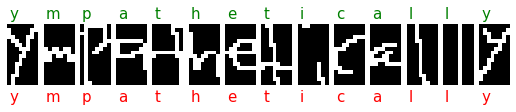

In [25]:
if not grading:
    nb_labels = torch.max(letters_dataset[0][1]).item()
    x_size = np.prod(letters_dataset[0][0].shape[1])
    mlpcrf_letters_model = ConvCRFClassifier([32,16],[3,3], nb_labels, x_size)
    _, mlpcrf_letters_log = train(
        model=mlpcrf_letters_model,
        loss_fn=mlpcrf_clf_loss,
        dataset=letters_dataset,
        display_info_fn=letters_info_fn,
        n_epochs=100,
        lr=0.001,
        batch_size=200,
        use_mask=True,
        log_transitions=True,
    )




y_true:  [4, 21, 21, 8, 13, 6] ['e', 'v', 'v', 'i', 'n', 'g']
y_pred:  [4, 21, 21, 8, 13, 6] ['e', 'v', 'v', 'i', 'n', 'g']
----------


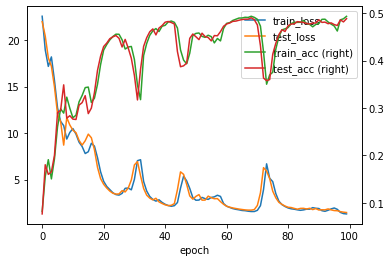

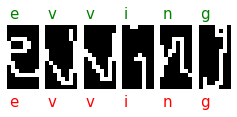

y_true:  [2, 10, 13, 14, 22, 11, 4, 3, 6, 4, 12, 4, 13, 19] ['c', 'k', 'n', 'o', 'w', 'l', 'e', 'd', 'g', 'e', 'm', 'e', 'n', 't']
y_pred:  [2, 10, 13, 14, 22, 11, 4, 3, 6, 4, 13, 4, 13, 19] ['c', 'k', 'n', 'o', 'w', 'l', 'e', 'd', 'g', 'e', 'n', 'e', 'n', 't']
----------


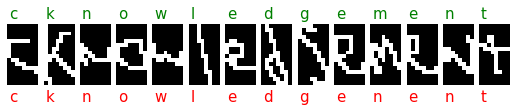

y_true:  [13, 3, 20, 18, 19, 17, 8, 0, 11, 8, 25, 4, 3] ['n', 'd', 'u', 's', 't', 'r', 'i', 'a', 'l', 'i', 'z', 'e', 'd']
y_pred:  [13, 16, 20, 18, 19, 8, 8, 0, 11, 8, 19, 4, 3] ['n', 'q', 'u', 's', 't', 'i', 'i', 'a', 'l', 'i', 't', 'e', 'd']
----------


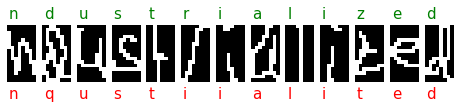

y_true:  [13, 13, 14, 20, 13, 2, 8, 13, 6] ['n', 'n', 'o', 'u', 'n', 'c', 'i', 'n', 'g']
y_pred:  [7, 13, 14, 20, 13, 2, 8, 13, 6] ['h', 'n', 'o', 'u', 'n', 'c', 'i', 'n', 'g']
----------


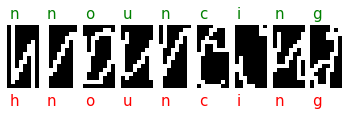

y_true:  [14, 12, 15, 0, 17, 0, 19, 8, 21, 4, 11, 24] ['o', 'm', 'p', 'a', 'r', 'a', 't', 'i', 'v', 'e', 'l', 'y']
y_pred:  [14, 12, 15, 14, 17, 0, 19, 8, 21, 4, 11, 24] ['o', 'm', 'p', 'o', 'r', 'a', 't', 'i', 'v', 'e', 'l', 'y']
----------


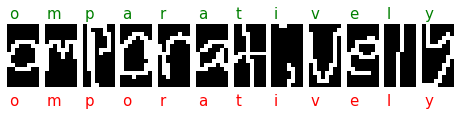

In [26]:
if not grading:
    nb_labels = torch.max(letters_dataset[0][1]).item()
    x_size = np.prod(letters_dataset[0][0].shape[1])
    mlpcrf_letters_model = ConvCRFClassifier([32,16],[3,3], nb_labels, x_size)
    _, mlpcrf_letters_log = train(
        model=mlpcrf_letters_model,
        loss_fn=mlpcrf_clf_loss,
        dataset=letters_dataset,
        display_info_fn=letters_info_fn,
        n_epochs=100,
        lr=0.003,
        batch_size=200,
        use_mask=True,
        log_transitions=True,
    )

## Wnioski do zadania 3

> tu wpisz wnioski

Accuracy uzyskiwane przed model bazujący na sieci konwolucyjnej cechują się bardziej 'poszarpanym' przebiegiem. Ostatecznie uzyskiwane wartości są zbliżone do tych uzyskiwanych przez poprzedni model. Dużym minusem jest dłuższy czas uczenia (z ok.2,5min -> 8,5min). Pomyłki występują dla przykładów, które nawet człowiekowi byłoby ciężko zaklasyfikować. Dodatkowo sam rozmiar obrazów jest na tyle mały, że CNN nie ma miejsca do popisu. Przy znacznie większych rozmiarach to właśnie sieć oparta o wartstwy konwolucyjne spodziewanie uzyskiwała by lepsze wyniki.

# PAMIĘTAJ O USTAWIENIU ZMIENNEJ GRADING NA `True`